# Atoti vs pandas Comparative Analysis for Value at Risk: Atoti Notebook

To compare the advanced analytics capabilities of Atoti with that of pandas, we will build a notebook that implements, **using Atoti**, the main components of a VaR use case:

* Compute VaR and ES:
    * At two different confidence levels: 95% and 99%
    * At three different granularities: top-of-house (global value for entire financial institution), combination of book and trade, and combination of all attributes
* Track, for each of those queries, the:
    * Response time
    * Memory usage
* We will also enrich the use case by:
    * Computing the incremental VaR
    * Performing simulations

💡 **Note:** This notebook downloads a dataset of ~5.5GB from Amazon S3, which may take some time to initially load depending on internet speed.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=atoti-pandas-comparison" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

## Imports

In [1]:
%load_ext memory_profiler

In [2]:
import atoti as tt
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from utils import progress_bar

## Session creation

Let's start by creating an Atoti session to host our in-memory data cube.

In [3]:
session = tt.Session.start(
    tt.SessionConfig(
        java_options=["-Xms1G", "-Xmx12G"],
    )
)

## Data model configuration

Once our session is up and running, we can start developing and configuring our data model. This will form the basis from which we build our cube and allows us to further enrich it and build an extensible semantic layer.

### Trade PnL table

Our trade table is the main table that contains all the trades, some of their attributes, and, most importantly, their Profit-and-Loss (PnL) vectors.

We will define the structure of the table, then feed it from our S3 repository. This will be a rather large dataset, which will allow us to perform our comparative analysis at a significant level.

In [4]:
trades_atoti = session.create_table(
    "TRADE_PNLS",
    data_types={
        "BOOKID": tt.type.DOUBLE,
        "ASOFDATE": tt.type.LOCAL_DATE,
        "TRADEID": tt.type.STRING,
        "DATASET": tt.type.STRING,
        "RISKFACTOR": tt.type.STRING,
        "RISKCLASS": tt.type.STRING,
        "SENSITIVITYNAME": tt.type.STRING,
        "CCY": tt.type.STRING,
        "TID": tt.type.DOUBLE,
        "PNL_VECTOR": tt.type.DOUBLE_ARRAY,
    },
    default_values={"BOOKID": 0.0, "TID": 0.0},
)

In [5]:
# Use anonymous access with boto3 (required for accessing a public S3 bucket)
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED, read_timeout=1200))
bucket = s3.Bucket("data.atoti.io")
objects = bucket.objects.filter(Prefix="notebooks/atoti-pandas-comparison/data/pnl")

# Get total number of files for progress bar calculation and initialize counter
total_files = sum(1 for obj in objects if obj.key.endswith(".parquet"))
file_count = 1

# Iterate over files in the S3 bucket and display the progress bar
for obj in objects:
    file = f"s3://{bucket.name}/{obj.key}"
    if file != "s3://data.atoti.io/notebooks/atoti-pandas-comparison/data/pnl/":
        progress_bar.print_progress_bar(
            file_count,
            total_files,
            prefix=f"Loading {file_count} / {total_files} files",
            suffix="Complete",
            length=50,
        )
        trades_atoti.load(tt.ParquetLoad(file))
        file_count += 1

trades_atoti.head()

Loading 31 / 31 files |██████████████████████████████████████████████████| 100.0% Complete

,BOOKID,ASOFDATE,TRADEID,DATASET,RISKFACTOR,RISKCLASS,SENSITIVITYNAME,CCY,TID,PNL_VECTOR
0,1.0,2021-05-11,BOND_Allegheny Energy 915efcc3,Historical,Credit spread_Allegheny Energy_Implied spread,Credit spread,delta,EUR,7454.0,"[-1277.1016253973248, -170.05582820769533, 587..."
1,1.0,2021-05-11,BOND_Allegheny Energy dfdb9532,Stressed,Foreign exchange_USD_Spot price,Foreign exchange,delta,EUR,50816.0,"[14134.836828742777, -8170.150573731592, 11957..."
2,1.0,2021-05-11,BOND_Asahi Breweries a98f5b72,Stressed,N/A,NA,N/A,EUR,52301.0,"[-399.043993864588, 849.6316941171951, 144.111..."
3,1.0,2021-05-11,BOND_Asahi Breweries ee86eee1,Historical,Interest rate_GBP.OIS_Implied yield,Interest rate,delta,EUR,58700.0,"[8.003878991156395, 6.004630704096847, 20.0014..."
4,1.0,2021-05-11,BOND_Asahi Chemical Ind. 9611fd42,Historical,Interest rate_CNY.OIS_Implied yield,Interest rate,delta,EUR,71570.0,"[-604.2203876593273, 277.0394967472273, -681.6..."


### Book table

The book table will enrich the data model with information about the books that contain our trades.

In [6]:
books_atoti = session.read_csv(
    "s3://data.atoti.io/notebooks/atoti-pandas-comparison/data/books.csv",
    table_name="BOOKS",
    keys=["BOOKID"],
)
books_atoti.head()

,BOOK,TRADING_DESK,SUB_BUSINESS_UNIT,BUSINESS_UNIT
BOOKID,,,,
13,HY013,Hypnos,Emerging Market,Forex
27,MI027,Minos,Frontier Market,Forex
41,AR041,Ares,Frontier Market,Forex
55,DE055,Demeter,Frontier Market,Forex
69,HR069,Heracles,Domestic Equity,Equity


### Join tables

In [7]:
trades_atoti.join(books_atoti, trades_atoti["BOOKID"] == books_atoti["BOOKID"])

## Semantic layer

### Cube creation

Our underlying data model is defined by joining the different tables. All that's left is to build a cube on top of it.

In [8]:
cube = session.create_cube(trades_atoti, mode="no_measures")
cube.shared_context["queriesResultLimit.transientLimit"] = 10000000
cube.shared_context["queriesResultLimit.intermediateLimit"] = 10000000

m, l, h = cube.measures, cube.levels, cube.hierarchies

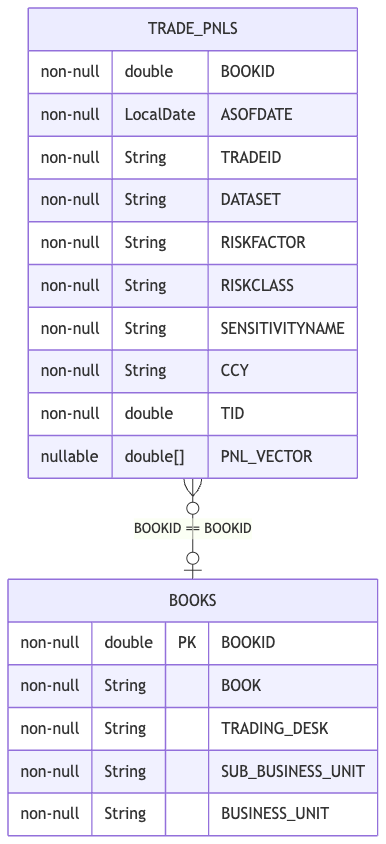

In [9]:
session.tables.schema

### Hierarchy configuration

Here we add the `BOOKID` hierarchy to be used in the queries, and create a multi-level hierarchy that will allow us to define and compute an incremental VaR measure down the line.

In [10]:
h["BOOKID"] = [trades_atoti["BOOKID"]]

In [11]:
h["Trading Book Hierarchy"] = {
    "Desk": l["TRADING_DESK"],
    "Book": l["BOOK"],
}

### Measure configuration

This is the part where most of the relevant metrics will be defined and added to the base cube. We start by loading our PnL vectors into a measure that makes it both queriable and usable by other subsequent measures, but also aggregates it at any desired level.

In [12]:
m["PNL_VECTOR"] = tt.agg.sum(trades_atoti["PNL_VECTOR"])

### VAR 95%

#### Computing VaR and ES, defined once, yet applicable to any level of aggregation

Since the `PNL_VECTOR` measure defined above implicitly manages the aggregation of the vectors at any queried level, the only thing left to do to obtain our VaR metrics is to apply the necessary statistical functions on top of it. 

Each of the metrics will only be defined once, yet it will be queriable and computable at **any required granularity of level of aggregation**, which saves us a lot of typing and redundancy compared to pandas, where each level of aggregation would require its own block of code.

In [13]:
m["VaR95"] = tt.array.quantile(m["PNL_VECTOR"], 1 - 0.95)
m["VaR99"] = tt.array.quantile(m["PNL_VECTOR"], 1 - 0.99)
m["ES95"] = tt.array.mean(tt.array.n_lowest(m["PNL_VECTOR"], n=12))

#### Incremental VaR (Parent VAR - Parent VAR excluding self)

Going even further, and thanks to the semantic dimension introduced by Atoti, the cube understands the hierarchical order and relationship between the different levels of a multi-level hierarchy, and provides functions and elements that leverage those semantics to derive measures based off of those relationships **(the `SiblingsScope` scope and the `parent_value()` function).**

In [14]:
# Aggregated vector at parent level, excluding self
m["Parent PnL Vector Ex"] = tt.agg.sum(
    m["PNL_VECTOR"],
    scope=tt.SiblingsScope(hierarchy=h["Trading Book Hierarchy"], exclude_self=True),
)

# VaR at the parent level
m["Parent VaR95"] = tt.parent_value(
    m["VaR95"], degrees={h["Trading Book Hierarchy"]: 1}
)

# VaR at the parent level excluding self
m["Parent VaR95 Ex"] = tt.array.quantile(m["Parent PnL Vector Ex"], (0.05))

# Incremental VaR
m["Incremental VaR95"] = m["Parent VaR95"] - m["Parent VaR95 Ex"]

## Performing the analytics

### Using Atoti UI widgets

We will use the Active UI JupyterLab extension to embed widgets and visualize our desired data within the notebook.
Within one widget, we are able to visualize and analyze all of our VaR metrics, at all 3 aggregation levels (Top-of-house is on the Totals row, and you can drill down to get down to the book and trade levels with a couple of clicks).

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
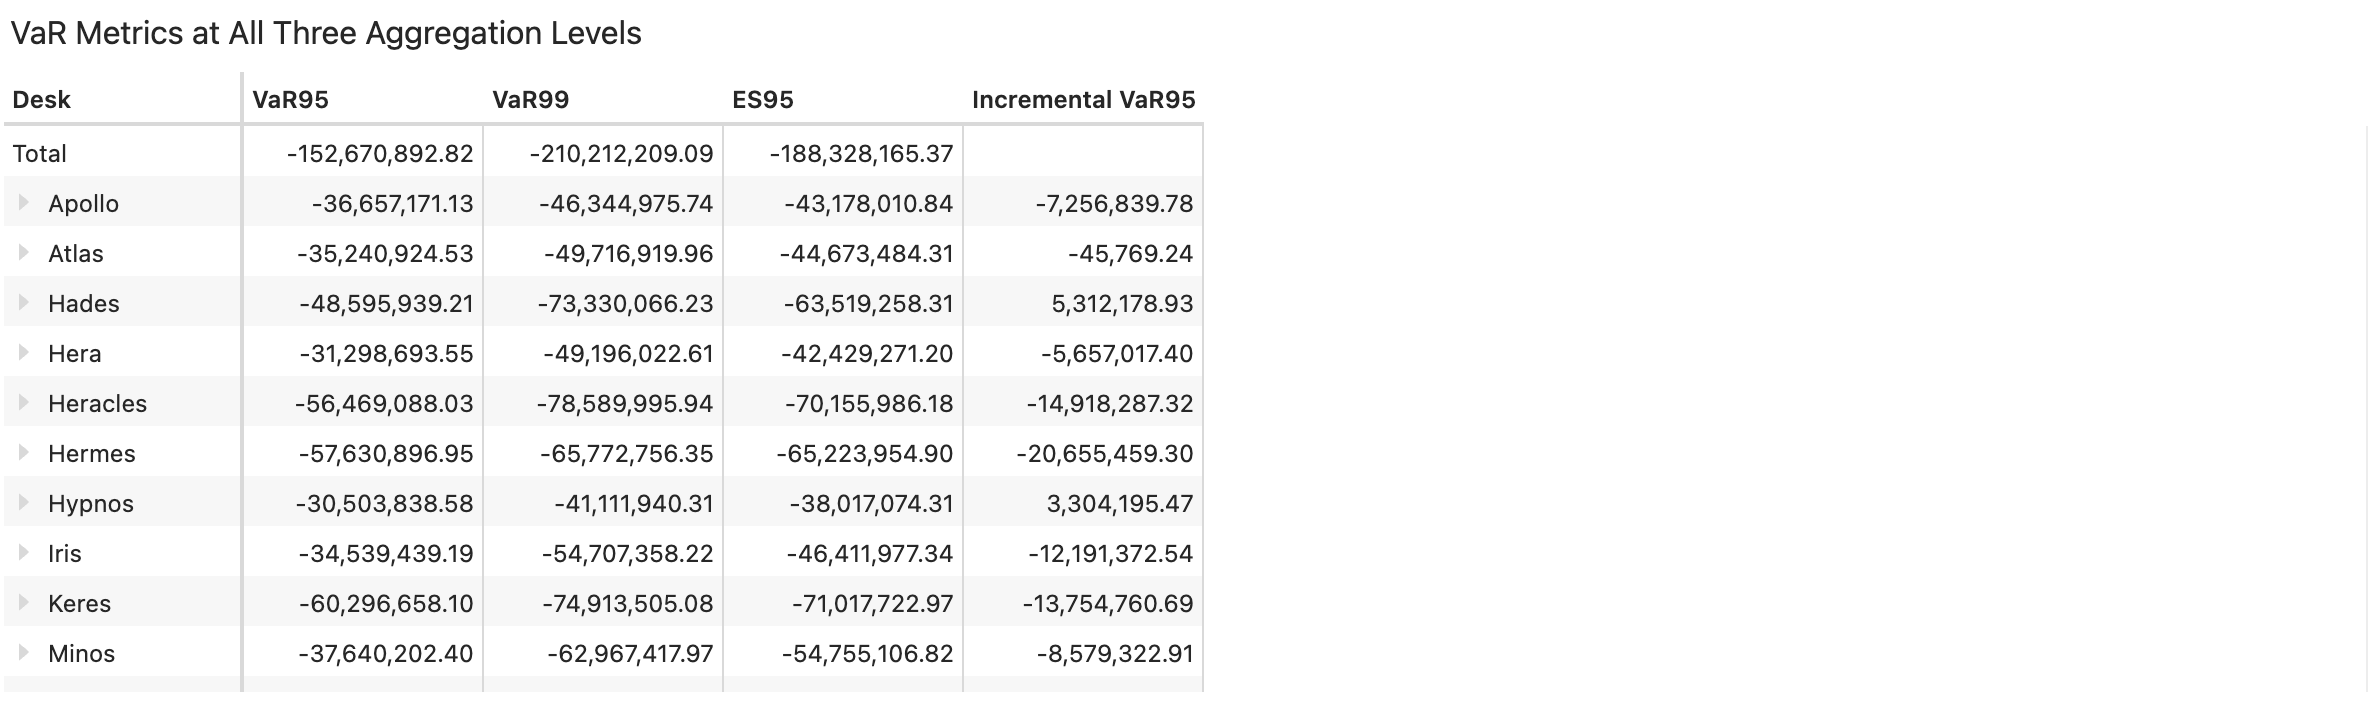

In [15]:
session.widget

### Performing queries against the cube

While the Atoti UI is a native and integral part of Atoti, which facilitates readily accessible, streamlined, and optimized analytics on top of the cube, Atoti also allows code-based queries against the cube that return a DataFrame as a result. 

We will now perform these queries in order to have **a fair basis for comparison** against the outputs of the pandas implementation. However, keep in mind that even though these Atoti queries are optimized and will outperform the pandas approach every time, using the Atoti UI will provide an even better outcome.

The **`time` and `memit` magic commands** are used to track, respectively, the **response times** and **memory usages** of these queries.

#### Computing Top of House VaR and ES

In [16]:
%%time
%%memit

cube.query(m['VaR95'], m['VaR99'], m['ES95'], mode='raw')

peak memory: 212.42 MiB, increment: 2.80 MiB
CPU times: user 60 ms, sys: 13.8 ms, total: 73.7 ms
Wall time: 590 ms


#### Computing VaR and ES at BookId and TradeId Level

In [17]:
%%time
%%memit

cube.query(m['VaR95'], m['VaR99'], m['ES95'], levels=[l['ASOFDATE'], l['BOOKID'], l['TRADEID']], mode='raw')

peak memory: 292.55 MiB, increment: 80.12 MiB
CPU times: user 86.4 ms, sys: 27.9 ms, total: 114 ms
Wall time: 4.78 s


#### Computing VaR and ES at the most granular level (combination of all available qualitative hierarchies) 

In [18]:
cube.hierarchies

{('TRADE_PNLS', 'RISKCLASS'): <atoti.hierarchy.Hierarchy object at 0x126698ed0>, ('TRADE_PNLS', 'TRADEID'): <atoti.hierarchy.Hierarchy object at 0x121c53710>, ('TRADE_PNLS', 'ASOFDATE'): <atoti.hierarchy.Hierarchy object at 0x121c53f50>, ('TRADE_PNLS', 'CCY'): <atoti.hierarchy.Hierarchy object at 0x11793d4d0>, ('TRADE_PNLS', 'SENSITIVITYNAME'): <atoti.hierarchy.Hierarchy object at 0x126697850>, ('TRADE_PNLS', 'RISKFACTOR'): <atoti.hierarchy.Hierarchy object at 0x126697d10>, ('TRADE_PNLS', 'DATASET'): <atoti.hierarchy.Hierarchy object at 0x126697f90>, ('TRADE_PNLS', 'BOOKID'): <atoti.hierarchy.Hierarchy object at 0x126697290>, ('BOOKS', 'BOOK'): <atoti.hierarchy.Hierarchy object at 0x126695650>, ('BOOKS', 'SUB_BUSINESS_UNIT'): <atoti.hierarchy.Hierarchy object at 0x126695a90>, ('BOOKS', 'BUSINESS_UNIT'): <atoti.hierarchy.Hierarchy object at 0x126695550>, ('BOOKS', 'TRADING_DESK'): <atoti.hierarchy.Hierarchy object at 0x126696390>, ('BOOKS', 'Trading Book Hierarchy'): <atoti.hierarchy.Hierarchy object at 0x126696510>}

In [19]:
%%time
%%memit

cube.query(m['VaR95'], m['VaR99'], m['ES95'], levels=[l['ASOFDATE'], l['BUSINESS_UNIT'], l['SUB_BUSINESS_UNIT'], l['TRADING_DESK'] , l['BOOKID'], l['RISKCLASS'], l['TRADEID']], mode='raw')

peak memory: 960.05 MiB, increment: 667.47 MiB
CPU times: user 354 ms, sys: 111 ms, total: 464 ms
Wall time: 9.65 s


## What-if scenarios

Going beyond the VaR metrics, Atoti facilitates other components of advanced analytics, such as performing simulations by leveraging its built-in branching capabilities.

Here, we will create a new branch, or scenario, where we will be able to load in a stressed version of our dataset. Then, by simply adding the `Source Simulation` or `Scenario` hierarchy on our columns, we obtain a side-by-side comparison of how each of our measures evaluate for each of our scenarios.

This is extremely optimized as any additional branch will only store and keep track of the data points that present a difference compared to the base branch.

In [20]:
addon_scenario = trades_atoti.scenarios["Stress-Test"]
addon_scenario.load(
    tt.ParquetLoad(
        "s3://data.atoti.io/notebooks/atoti-pandas-comparison/data/simulation/pnl_16.parquet"
    )
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
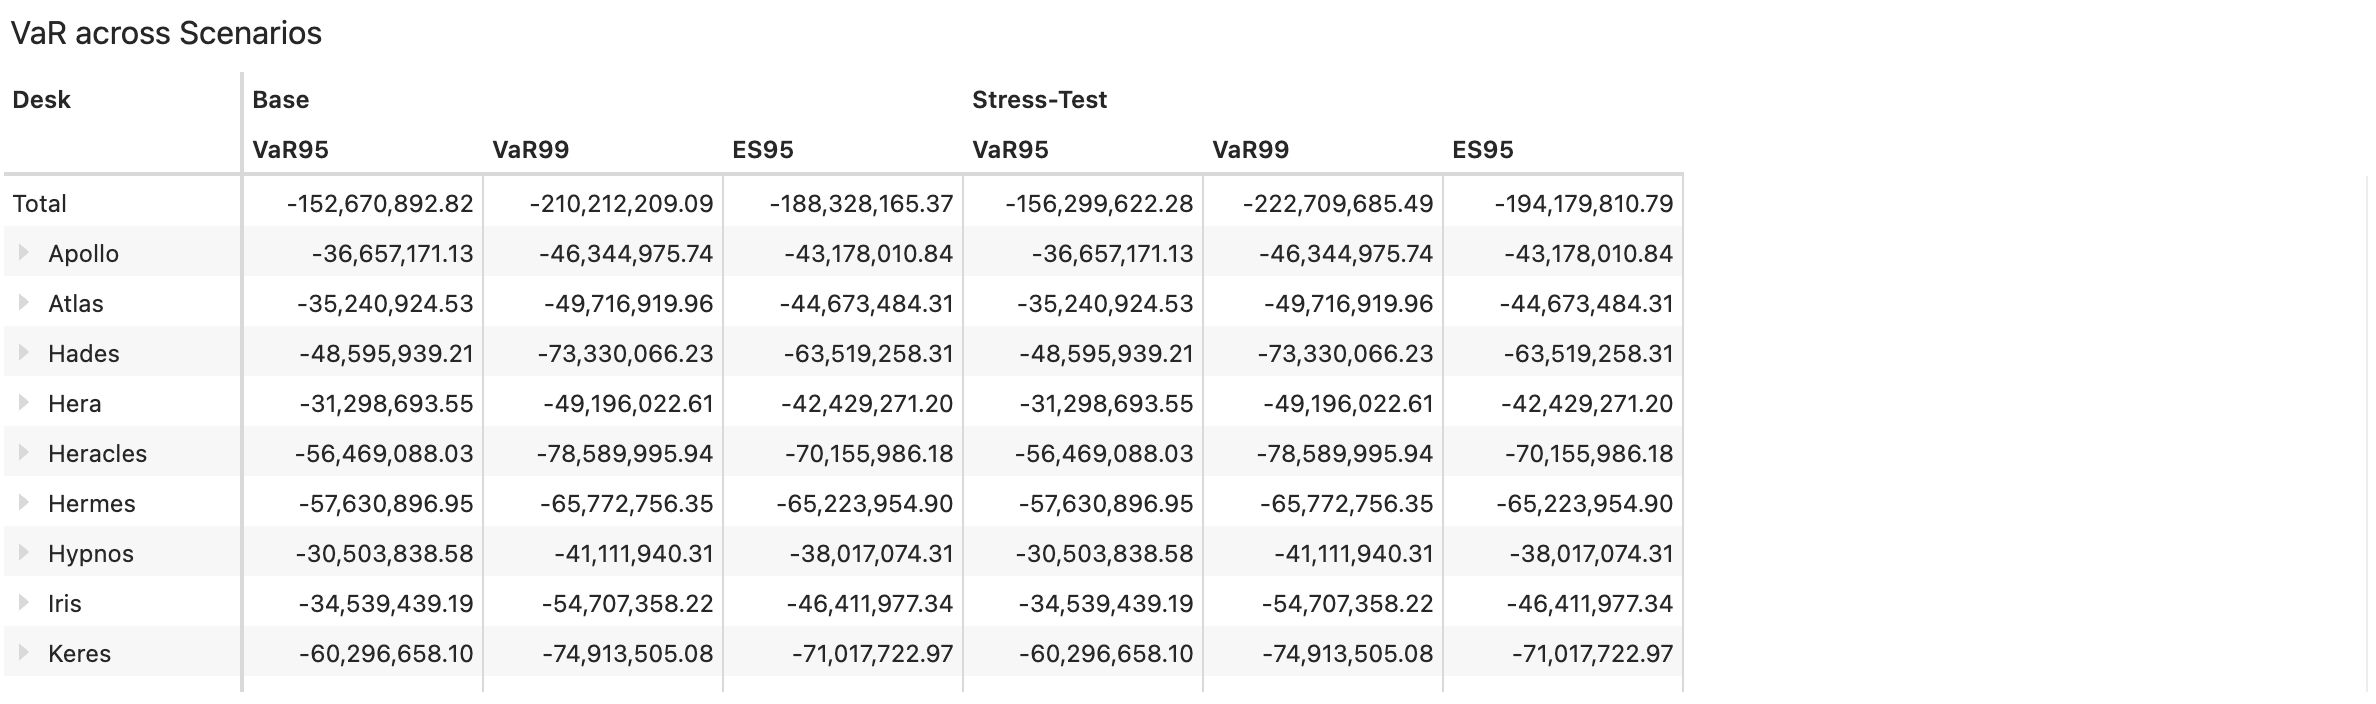

In [21]:
session.widget

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=atoti-pandas-comparison" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>